# Controllers

To actively manipulate the computing or energy systems during experiments, we need to implement a custom `Controller`.

In this example, our controller will adjust the power consumption of the compute nodes depending on the current power delta. 

In [1]:
from __future__ import annotations
from vessim.actor import ComputingSystem, Generator
from vessim.controller import Controller, Monitor
from vessim.cosim import Environment
from vessim.power_meter import MockPowerMeter
from vessim.signal import HistoricalSignal
from vessim.storage import SimpleBattery

# Hotfix to execute asyncio in Jupyter
import nest_asyncio
nest_asyncio.apply()

The most important aspect of this procedure is the implementation of the
`step()` method, which needs to be implemented as dictated by the Controller
ABC. The `step()` method is called every simulation step and allows a Controller
to act on the power delta from the Microgrid, the current simulation time and
the activity of the Actors. The `SimpleLoadBalancingController` only utilizes
the power delta and adjusts, depending on this value, the power consumption of
the computing system and in turn the power delta in the next simulation step.

In [2]:
class SimpleLoadBalancingController(Controller):
    def __init__(self, power_meters: list[MockPowerMeter]):
        super().__init__()
        self.power_meters = power_meters
        # save original meter power consumption
        self.meter_p = {meter.name: meter.measure() for meter in self.power_meters}

    def start(self, microgrid) -> None:
        pass

    def step(self, time: int, p_delta: float, actor_infos: dict) -> None:
        for power_meter in self.power_meters:
            new_power = self.meter_p[power_meter.name]
            if p_delta < 0:
                new_power *= 0.3
            power_meter.set_power(new_power)

Now we can add the controller to the basic scenario by instantiating it with a
reference to the power meters it can control and the maximum load adjustment for
each step. The rest of the scenario remains unchanged.

In [3]:
environment = Environment(sim_start="2022-06-09 00:00:00")

power_meters: list = [
    MockPowerMeter(p=200),
    MockPowerMeter(p=250),
]
monitor = Monitor()  # Stores simulation result on each step
load_balancer = SimpleLoadBalancingController(power_meters=power_meters)
environment.add_microgrid(
    actors=[
        ComputingSystem(power_meters=power_meters, pue=1.6),
        Generator(
            signal=HistoricalSignal.from_dataset("solcast2022_global", params={"scale": 5000}),
            column="Berlin",
        ),
    ],
    storage=SimpleBattery(capacity=100 * 3600, charge_level=80 * 3600),
    controllers=[monitor, load_balancer],
    step_size=60,  # Global step size (can be overridden by actors or controllers)
)

environment.run(until=24 * 3600)  # 24h
monitor.to_csv("result.csv")

2024-04-15 10:31:36.188 | INFO     | mosaik.scenario:start:280 - Starting "Actor" as "Actor-0" ...
2024-04-15 10:31:36.189 | INFO     | mosaik.scenario:start:280 - Starting "Actor" as "Actor-1" ...
2024-04-15 10:31:36.189 | INFO     | mosaik.scenario:start:280 - Starting "Grid" as "Grid-0" ...
2024-04-15 10:31:36.190 | INFO     | mosaik.scenario:start:280 - Starting "Controller" as "Controller-0" ...
2024-04-15 10:31:36.191 | INFO     | mosaik.scenario:start:280 - Starting "Controller" as "Controller-1" ...
2024-04-15 10:31:36.193 | INFO     | mosaik.scenario:run:598 - Starting simulation.
100%|██████████| 86400/86400 [00:00<00:00, 125042.83steps/s]
2024-04-15 10:31:36.886 | INFO     | mosaik.scenario:run:646 - Simulation finished successfully.


Compared to the basic example, our computing system utilizes less power from the grid when solar energy production is inadequate, thanks to our load balancer.

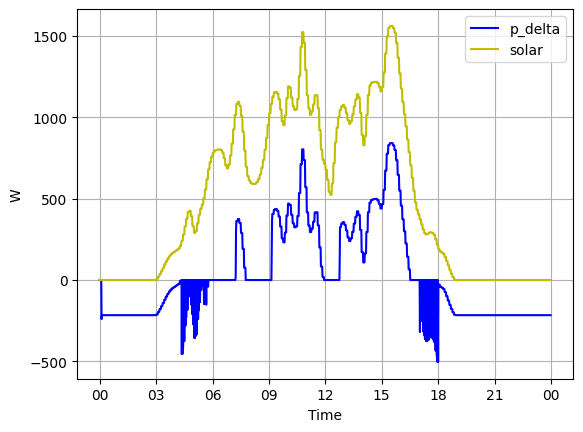

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = pd.read_csv("result.csv", parse_dates=[0], index_col=0)

fig, ax1 = plt.subplots()

ax1.plot(df.index, df["p_delta"], color="b", label="p_delta")
ax1.legend()
ax1.plot(df.index, df["actor_infos.Generator-0.p"], color="y", label="solar")
ax1.legend()
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
ax1.grid()
ax1.set_xlabel("Time")
ax1.set_ylabel("W")

plt.show()